In [1]:
#General imports
import numpy as np
from tqdm.notebook import tqdm

In [2]:
#Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata
import torch.optim as optim

/home/ivanoleksiyuk/WORK/jet_clip/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Plotting
import matplotlib.pyplot as plt

In [4]:
#Local imports 
from encodermodels import SimpleConvNetEncoder
from datasets import DataManager
from clip_loss import CLIPLoss

In [5]:
#Fetching the device that will be used throughout this notebook
device = torch.device(
    "cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0



DEFINE DATA AND HYPERPARAMETERS

In [6]:
data_config = "QCD1f"
batch_size = 64 #256
latent_dims=10
# %%
# DEFINE A DATASET MANAGER
DM = DataManager(data_config=data_config, transform=None)

In [7]:
#Create data loaders 
train_loader = torchdata.DataLoader(
    DM.train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torchdata.DataLoader(
    DM.val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_bg_loader = torchdata.DataLoader(
    DM.test_bg, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)
test_sg_loader = torchdata.DataLoader(
    DM.test_sg, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

In [8]:
#Create model
clip_loss = CLIPLoss()
encoder1 = SimpleConvNetEncoder(latent_dims=latent_dims)
encoder1.to(device)
encoder2 = SimpleConvNetEncoder(latent_dims=latent_dims)
encoder2.to(device)
optimizer = optim.Adam(list(encoder1.parameters()) +
                       list(encoder2.parameters()), lr=0.0001)

In [9]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs = data[0].reshape(
            data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
        inputs = inputs.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        embedding1 = encoder1(inputs)
        embedding2 = encoder2(inputs)
        loss = clip_loss.forward(embedding1, embedding2)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += clip_loss.item()
        print_T = 200
        if i % print_T == print_T-1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_T:.6f}')
            running_loss = 0.0
    
    #Validation once per epoch 
    valid_loss = 0.0
    for i, data in enumerate(val_loader):
        inputs = data[0].reshape(
            data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
        inputs = inputs.to(device)

        # forward + backward + optimize
        with torch.no_grad():
            embedding1 = encoder1(inputs)
            embedding2 = encoder2(inputs)
            loss = clip_loss.forward(embedding1, embedding2)

        # print statistics
        valid_loss += clip_loss.item()
    print(valid_loss/i)
    

[1,   200] loss: 3.907022
[1,   400] loss: 3.617318
[1,   600] loss: 3.581256
[1,   800] loss: 3.570213
[1,  1000] loss: 3.533919
[1,  1200] loss: 3.474386
[1,  1400] loss: 3.431137
3.421433162230712
[2,   200] loss: 3.413875
[2,   400] loss: 3.405341
[2,   600] loss: 3.396124
[2,   800] loss: 3.382950
[2,  1000] loss: 3.376675
[2,  1200] loss: 3.367369
[2,  1400] loss: 3.364230
3.362747020446337
[3,   200] loss: 3.362373
[3,   400] loss: 3.359091
[3,   600] loss: 3.353548
[3,   800] loss: 3.356133
[3,  1000] loss: 3.350066
[3,  1200] loss: 3.348768
[3,  1400] loss: 3.337914
3.334670073710955
[4,   200] loss: 3.334532
[4,   400] loss: 3.331294
[4,   600] loss: 3.324380
[4,   800] loss: 3.325996
[4,  1000] loss: 3.324100
[4,  1200] loss: 3.323753
[4,  1400] loss: 3.322833
3.3254004972867475
[5,   200] loss: 3.321870
[5,   400] loss: 3.324075
[5,   600] loss: 3.321747
[5,   800] loss: 3.319838
[5,  1000] loss: 3.321384
[5,  1200] loss: 3.320042
[5,  1400] loss: 3.321160
3.325201769669851

In [ ]:
data = next(iter(train_loader))
data[0]=data[0][:10]
inputs = data[0].reshape(
            data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
inputs = inputs.to(device)
with torch.no_grad():
	embedding_1 = encoder1.forward(inputs)
	embedding_2 = encoder2.forward(inputs)

In [ ]:
if latent_dims==2:
	plt.scatter([0], [0], c="black")
	xy=embedding_1.cpu().detach().numpy()
	plt.scatter(xy[:, 0], xy[:, 1], c=np.arange(len(xy[:, 0])), cmap='turbo')
	xy=embedding_2.cpu().detach().numpy()
	plt.scatter(xy[:, 0], xy[:, 1], c=np.arange(len(xy[:, 0])), cmap='turbo')

<AxesSubplot: >

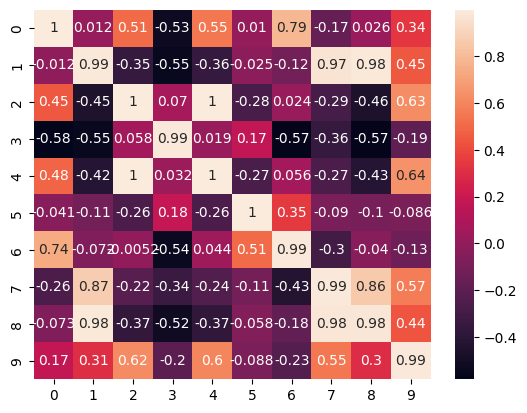

In [ ]:
logits_1 = embedding_1 @ embedding_2.T
logits_2 = embedding_2 @ embedding_1.T
#print(logits_1)
#print(logits_2)
import seaborn as sns

sns.heatmap(logits_1.cpu().detach().numpy(), annot=True)


<AxesSubplot: >

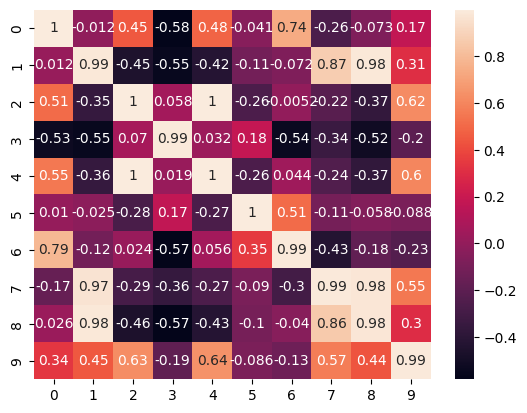

In [ ]:
sns.heatmap(logits_2.cpu().detach().numpy(), annot=True)

In [ ]:
num_logits = logits_1.shape[0]
labels = torch.arange(num_logits, device=device, dtype=torch.long)
print(labels)
print(F.cross_entropy(logits_1, labels))
print(F.cross_entropy(logits_2, labels))
loss = 0.5 * (
	F.cross_entropy(logits_1, labels) +
	F.cross_entropy(logits_2, labels)
)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
tensor(1.5854, device='cuda:0')
tensor(1.5855, device='cuda:0')


In [ ]:
def evaluate_from_loader(data_loader):
    scores = []
    for i, data in enumerate(data_loader):
        inputs = data[0].reshape(
            data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
        inputs = inputs.to(device)

        #forward + backward + optimize
        with torch.no_grad():
            embedding1 = encoder1(inputs)
            embedding2 = encoder2(inputs)
            similarity = torch.diagonal(embedding1 @ embedding2.T)
        scores.append(similarity)
    scores=torch.concat(scores)
    scores=1-scores.cpu().detach().numpy()
    return scores

bg_ev_sc=evaluate_from_loader(test_bg_loader)
sg_ev_sc=evaluate_from_loader(test_sg_loader)

(array([1.2357e+04, 7.7090e+03, 4.7430e+03, 3.2590e+03, 2.3220e+03,
        1.6600e+03, 1.3370e+03, 1.0130e+03, 8.2000e+02, 6.5000e+02,
        5.4700e+02, 4.6500e+02, 4.1100e+02, 2.8000e+02, 2.9700e+02,
        2.0300e+02, 2.1200e+02, 1.3400e+02, 1.5000e+02, 1.3400e+02,
        1.0500e+02, 9.9000e+01, 8.5000e+01, 7.0000e+01, 6.1000e+01,
        5.8000e+01, 5.9000e+01, 5.3000e+01, 4.8000e+01, 4.5000e+01,
        4.7000e+01, 4.4000e+01, 2.2000e+01, 3.3000e+01, 2.8000e+01,
        3.1000e+01, 1.9000e+01, 2.0000e+01, 2.3000e+01, 1.8000e+01,
        1.9000e+01, 1.5000e+01, 8.0000e+00, 1.2000e+01, 5.0000e+00,
        8.0000e+00, 1.4000e+01, 1.8000e+01, 1.4000e+01]),
 array([0.        , 0.00204082, 0.00408163, 0.00612245, 0.00816327,
        0.01020408, 0.0122449 , 0.01428571, 0.01632653, 0.01836735,
        0.02040816, 0.02244898, 0.0244898 , 0.02653061, 0.02857143,
        0.03061224, 0.03265306, 0.03469388, 0.03673469, 0.03877551,
        0.04081633, 0.04285714, 0.04489796, 0.04693878, 0.

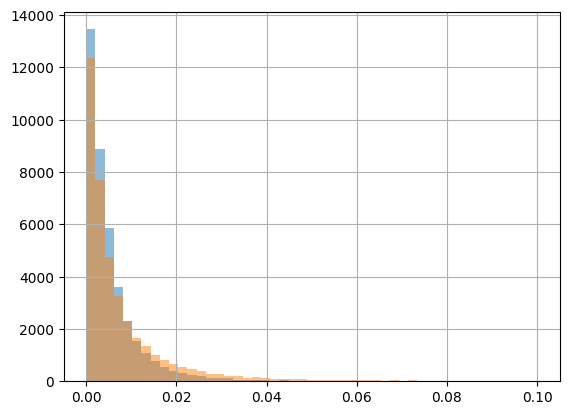

In [ ]:
plt.figure()
plt.grid()
plt.hist(bg_ev_sc, bins=np.linspace(0, 0.1, 50), alpha=0.5, label="background")
plt.hist(sg_ev_sc, bins=np.linspace(0, 0.1, 50), alpha=0.5, label="signal")

/tmp/ipykernel_4696/279896834.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr)
/tmp/ipykernel_4696/279896834.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.linspace(0, 1, 1000), 1/np.linspace(0, 1, 1000), color="gray")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'eval_path' is not defined

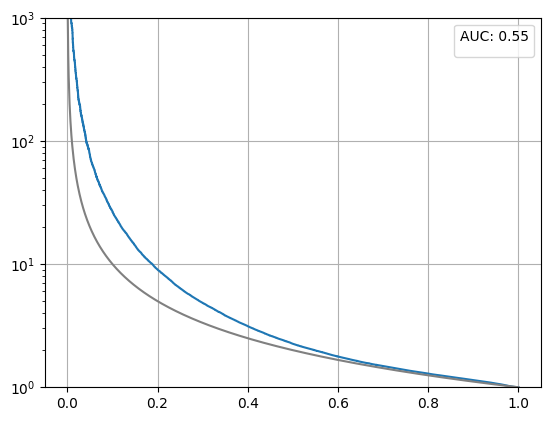

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
labels=np.concatenate((np.zeros(len(bg_ev_sc)), np.ones(len(sg_ev_sc))))
auc = roc_auc_score(labels, np.append(bg_ev_sc, sg_ev_sc))
fpr , tpr , thresholds = roc_curve(labels, np.append(bg_ev_sc, sg_ev_sc))
plt.figure()
plt.grid()
plt.plot(tpr, 1/fpr)
plt.ylim(ymin=1, ymax=1000)
plt.plot(np.linspace(0, 1, 1000), 1/np.linspace(0, 1, 1000), color="gray")
plt.yscale("log")
plt.legend(title=f'AUC: {auc:.2f}')
plt.savefig(eval_path+"/ROC.png")